<a href="https://colab.research.google.com/github/emerymoriconi/processamento-digital-de-imagens/blob/main/pdi_atividade02.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# PROCESSAMENTO DIGITAL DE IMAGENS

Aluna: Émery Freitas Moriconi - 20229004598

Departamento de Computação - UFPI

Disciplina: Processamento Digital de Imagens - 2023.2

Professor: Kelson R. T. Aires

In [ ]:
import PIL
from PIL import Image

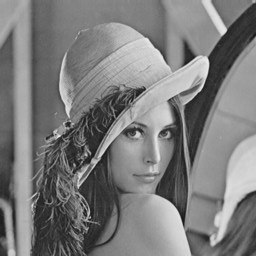

In [ ]:
lena = Image.open('/content/lena_gray.bmp')
lena

**OPERAÇÕES - LAPLACIANO**

*Detecção de bordas finas.*

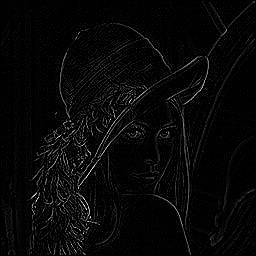

In [ ]:
import numpy as np

def laplaciano(imagem):
  imagem_array = np.array(imagem)

  mascara = np.array([[0, -1, 0],
                      [-1, 4, -1],
                      [0, -1, 0]])

  altura, largura = imagem_array.shape

  #criando uma matriz para armazenar o resultado da convolução
  resultado = np.zeros((altura, largura))

  #aplicando a convolução pixel a pixel
  for i in range(1, altura-1):
      for j in range(1, largura-1):
        #extrai uma matriz 3x3 da imagem em torno do pixel central (i, j)
          resultado[i, j] = np.sum(imagem_array[i-1:i+2, j-1:j+2] * mascara)

  #normalizando os valores para o intervalo [0, 255]
  resultado = np.clip(resultado, 0, 255)

  #convertendo de volta para o tipo de dados uint8
  resultado = resultado.astype(np.uint8)

  return Image.fromarray(resultado)

resultado = laplaciano(lena)

resultado

**OPERAÇÕES - UNSHARP MASKING**

*Imagem_Nitida = Imagem_Original + Fator_Intensidade × (Imagem_Original − Imagem_Suavizada)*


Geralmente, um fator de intensidade maior no Unsharp Masking resulta em uma imagem mais nítida. O fator de intensidade controla a força com que a máscara (diferença entre a imagem original e a imagem suavizada) é aplicada à imagem original. Aumentar o fator de intensidade amplifica essa diferença e, consequentemente, aumenta o efeito de nitidez.

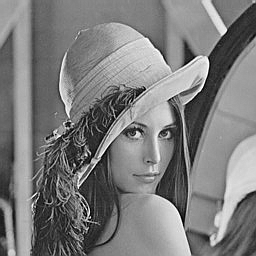

In [ ]:
from PIL import Image, ImageFilter

def unsharp_masking(imagem, fator_intensidade):
    #convertendo a imagem para escala de cinza se não estiver
    imagem = imagem.convert('L')

    #obtendo os pixels da imagem
    pixels = imagem.load()

    #obtendo a largura e altura da imagem
    largura, altura = imagem.size

    #criando uma cópia da imagem para armazenar o resultado
    imagem_nitida = imagem.copy()

    #aplicando o Unsharp Masking pixel a pixel
    for i in range(1, largura-1):
        for j in range(1, altura-1):
            #obtendo os pixels na vizinhança 3x3
            vizinhanca = [pixels[x, y] for x in range(i-1, i+2) for y in range(j-1, j+2)]

            #calculando a média da vizinhança
            media_vizinhanca = sum(vizinhanca) / 9.0

            #calculando o valor do pixel na imagem suavizada
            pixel_suavizado = int(media_vizinhanca)

            #calculando a diferença entre o pixel original e o suavizado
            diferenca = pixels[i, j] - pixel_suavizado

            #aplicando o Unsharp Masking e ajustando o valor do pixel
            novo_pixel = int(pixels[i, j] + fator_intensidade * diferenca)

            #garantindo que o valor do pixel esteja no intervalo [0, 255]
            novo_pixel = max(0, min(255, novo_pixel))

            #atualizando o pixel na imagem resultante
            imagem_nitida.putpixel((i, j), novo_pixel)

    return imagem_nitida

# k = 1 : Unsharp Masking
# k > 1 : Highboost
lena_nitida = unsharp_masking(lena, 1)
lena_nitida

**OPERAÇÕES - HIGHBOOST**

*Nitidez da imagem.*

*HB = FATOR_DE_INTENSIDADE * (IMAGEM_ORIGINAL - IMAGEM_SUAVIZADA) + IMAGEM_ORIGINAL*

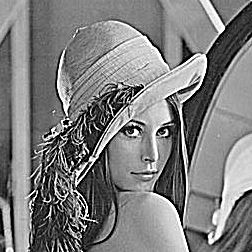

In [ ]:
def suavizacao_media(imagem):
  imagem_array = np.array(imagem)

  #máscara do filtro da média
  mascara = np.array([[1/25, 1/25, 1/25, 1/25, 1/25],
                      [1/25, 1/25, 1/25, 1/25, 1/25],
                      [1/25, 1/25, 1/25, 1/25, 1/25],
                      [1/25, 1/25, 1/25, 1/25, 1/25],
                      [1/25, 1/25, 1/25, 1/25, 1/25]])

  altura, largura = imagem_array.shape

  #criando uma matriz para armazenar o resultado da convolução
  resultado = np.zeros((altura, largura))

  #aplicando a convolução pixel a pixel
  for i in range(2, altura-2):
      for j in range(2, altura-2):
        #extrai uma matriz 5x5 da imagem em torno do pixel central (i, j)
          resultado[i, j] = np.sum(imagem_array[i-2:i+3, j-2:j+3] * mascara)

  #normalizando os valores para o intervalo [0, 255]
  resultado = np.clip(resultado, 0, 255)

  #convertendo de volta para o tipo de dados uint8
  resultado = resultado.astype(np.uint8)

  return Image.fromarray(resultado)

#função para realizar a filtragem Highboost
def highboost_filtro(imagem, fator_reforco):
    #convertendo a imagem para escala de cinza se não estiver
    imagem = imagem.convert('L')

    #obtendo a versão suavizada da imagem pela média
    imagem_suavizada = suavizacao_media(imagem)

    pixels_original = imagem.load()
    pixels_suavizada = imagem_suavizada.load()

    #obtendo as dimensões da imagem
    largura, altura = imagem.size

    #criando uma imagem para armazenar o resultado
    #cortamos as bordas pois o filtro da média criou um contorno de intensidade 0 indesejado
    imagem_resultante = Image.new('L', (largura-4, altura-4))
    pixels_resultante = imagem_resultante.load()

    #aplicando a filtragem Highboost pixel a pixel
    for i in range(1, largura-2):
        for j in range(1, altura-2):
            #calculando o valor do pixel na imagem resultante
            novo_pixel = int(fator_reforco * (pixels_original[i, j] - pixels_suavizada[i, j]) + pixels_original[i, j])

            #normalizando para o intervalo de 0 a 255
            novo_pixel = max(0, min(255, novo_pixel))

            #atualizando o pixel na imagem resultante
            pixels_resultante[i-2, j-2] = novo_pixel

    return imagem_resultante

resultado = highboost_filtro(lena, 3)

resultado

**DETECÇÃO DE BORDAS - FILTRO PREWITT**

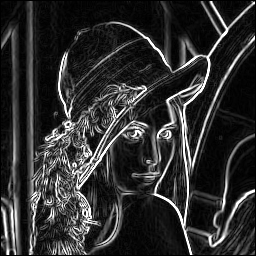

In [ ]:
def prewitt(imagem):
    imagem_array = np.array(imagem)

    # Máscara para detecção de bordas horizontais
    mascara_prewitt_horizontal = np.array([[-1, -1, -1],
                                           [0, 0, 0],
                                           [1, 1, 1]])

    # Máscara para detecção de bordas verticais
    mascara_prewitt_vertical = np.array([[-1, 0, 1],
                                         [-1, 0, 1],
                                         [-1, 0, 1]])

    altura, largura = imagem_array.shape

    # Criando matrizes para armazenar os resultados das convoluções
    resultado_horizontal = np.zeros((altura, largura))
    resultado_vertical = np.zeros((altura, largura))

    # Aplicando a convolução pixel a pixel para bordas horizontais
    for i in range(1, altura-1):
        for j in range(1, largura-1):
            resultado_horizontal[i, j] = np.sum(imagem_array[i-1:i+2, j-1:j+2] * mascara_prewitt_horizontal)

    # Aplicando a convolução pixel a pixel para bordas verticais
    for i in range(1, altura-1):
        for j in range(1, largura-1):
            resultado_vertical[i, j] = np.sum(imagem_array[i-1:i+2, j-1:j+2] * mascara_prewitt_vertical)

    # Combinando os resultados para obter bordas tanto horizontais quanto verticais
    resultado_combinado = np.sqrt(resultado_horizontal**2 + resultado_vertical**2)

    # Normalizando os valores para o intervalo [0, 255]
    resultado_combinado = np.clip(resultado_combinado, 0, 255)

    # Convertendo de volta para o tipo de dados uint8
    resultado_combinado = resultado_combinado.astype(np.uint8)

    return Image.fromarray(resultado_combinado)

resultado = prewitt(lena)
resultado

**DETECÇÃO DE BORDAS - FILTRO SOBEL**

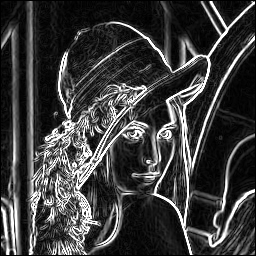

In [ ]:
def sobel(imagem):
    imagem_array = np.array(imagem)

    # Máscara para detecção de bordas horizontais
    mascara_sobel_horizontal = np.array([[-1, -2, -1],
                                         [0, 0, 0],
                                         [1, 2, 1]])

    # Máscara para detecção de bordas verticais
    mascara_sobel_vertical = np.array([[-1, 0, 1],
                                       [-2, 0, 2],
                                       [-1, 0, 1]])

    altura, largura = imagem_array.shape

    # Criando matrizes para armazenar os resultados das convoluções
    resultado_horizontal = np.zeros((altura, largura))
    resultado_vertical = np.zeros((altura, largura))

    # Aplicando a convolução pixel a pixel para bordas horizontais
    for i in range(1, altura-1):
        for j in range(1, largura-1):
            resultado_horizontal[i, j] = np.sum(imagem_array[i-1:i+2, j-1:j+2] * mascara_sobel_horizontal)

    # Aplicando a convolução pixel a pixel para bordas verticais
    for i in range(1, altura-1):
        for j in range(1, largura-1):
            resultado_vertical[i, j] = np.sum(imagem_array[i-1:i+2, j-1:j+2] * mascara_sobel_vertical)

    # Combinando os resultados para obter bordas tanto horizontais quanto verticais
    resultado_combinado = np.sqrt(resultado_horizontal**2 + resultado_vertical**2)

    # Normalizando os valores para o intervalo [0, 255]
    resultado_combinado = np.clip(resultado_combinado, 0, 255)

    # Convertendo de volta para o tipo de dados uint8
    resultado_combinado = resultado_combinado.astype(np.uint8)

    return Image.fromarray(resultado_combinado)

resultado = sobel(lena)
resultado

A diferença entre ambos os filtros se dá em imagens ruidosas, visto que, o fato de as máscaras de Sobel apresentarem melhor supressão de ruído (suavização), faz com que sejam preferíveis. Como a imagem 'lena_gray.bmp' não apresenta ruídos dominantes, a aplicação de ambos os filtros pode não apresentar muitas diferenças visíveis.

**FILTRO DA MEDIANA**

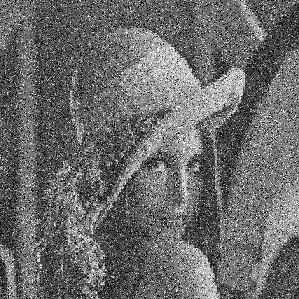

In [ ]:
lena_ruido = Image.open('/content/lena_ruido.bmp')
lena_ruido

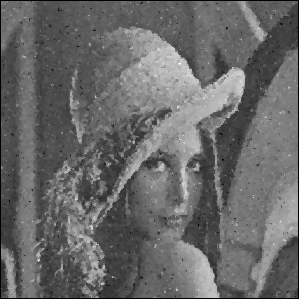

In [ ]:
def mediana(imagem):
  imagem_array = np.array(imagem)

  altura, largura = imagem_array.shape

  #criando uma matriz para armazenar o resultado da convolução
  resultado = np.zeros((altura, largura))

  #aplicando a convolução pixel a pixel
  for i in range(1, altura-1):
      for j in range(1, largura-1):
        #vizinhança
        vizinhos = [imagem_array[i-1, j-1],
                    imagem_array[i-1, j],
                    imagem_array[i-1, j + 1],
                    imagem_array[i, j-1],
                    imagem_array[i, j],
                    imagem_array[i, j + 1],
                    imagem_array[i + 1, j-1],
                    imagem_array[i + 1, j],
                    imagem_array[i + 1, j + 1]]

        vizinhos = sorted(vizinhos)

        resultado[i, j] = vizinhos[4]

  #convertendo de volta para o tipo de dados uint8
  resultado = resultado.astype(np.uint8)

  return Image.fromarray(resultado)

resultado = mediana(lena_ruido)

resultado

**MÁSCARA 1:**

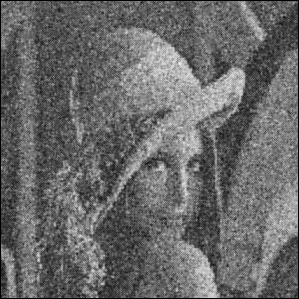

In [ ]:
def mascara1(imagem):
  imagem_array = np.array(imagem)

  mascara = np.array([[0, 1/5, 0],
                      [1/5, 1/5, 1/5],
                      [0, 1/5, 0]])

  altura, largura = imagem_array.shape

  #criando uma matriz para armazenar o resultado da convolução
  resultado = np.zeros((altura, largura))

  #aplicando a convolução pixel a pixel
  for i in range(1, altura-1):
      for j in range(1, largura-1):
          #vizinhança
          vizinhos = np.array([[imagem_array[i+1, j-1], imagem_array[i+1, j], imagem_array[i+1, j+1]],
                              [imagem_array[i, j-1], imagem_array[i, j], imagem_array[i, j+1]],
                              [imagem_array[i-1, j-1], imagem_array[i-1, j], imagem_array[i-1, j+1]]])

          #extrai uma matriz 3x3 da imagem em torno do pixel central (i, j)
          resultado[i, j] = np.sum(vizinhos * mascara)

  #normalizando os valores para o intervalo [0, 255]
  resultado = np.clip(resultado, 0, 255)

  #convertendo de volta para o tipo de dados uint8
  resultado = resultado.astype(np.uint8)

  return Image.fromarray(resultado)

resultado = mascara1(lena_ruido)

resultado

**MÁSCARA 2:**

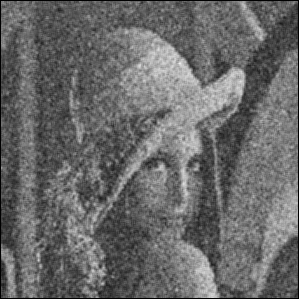

In [ ]:
def mascara2(imagem):
  imagem_array = np.array(imagem)

  #prioriza bordas na vertical
  mascara = np.array([[1/9, 1/9, 1/9],
                      [1/9, 1/9, 1/9],
                      [1/9, 1/9, 1/9]])

  altura, largura = imagem_array.shape

  #criando uma matriz para armazenar o resultado da convolução
  resultado = np.zeros((altura, largura))

  #aplicando a convolução pixel a pixel
  for i in range(1, altura-1):
      for j in range(1, largura-1):
          #vizinhança
          vizinhos = np.array([[imagem_array[i+1, j-1], imagem_array[i+1, j], imagem_array[i+1, j+1]],
                              [imagem_array[i, j-1], imagem_array[i, j], imagem_array[i, j+1]],
                              [imagem_array[i-1, j-1], imagem_array[i-1, j], imagem_array[i-1, j+1]]])

          #extrai uma matriz 3x3 da imagem em torno do pixel central (i, j)
          resultado[i, j] = np.sum(vizinhos * mascara)

  #normalizando os valores para o intervalo [0, 255]
  resultado = np.clip(resultado, 0, 255)

  #convertendo de volta para o tipo de dados uint8
  resultado = resultado.astype(np.uint8)

  return Image.fromarray(resultado)

resultado = mascara2(lena_ruido)

resultado

**MÁSCARA 3:**

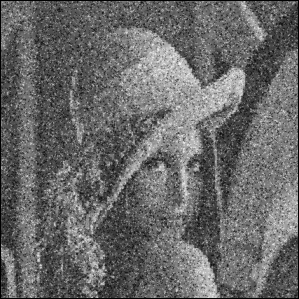

In [ ]:
def mascara3(imagem):
  imagem_array = np.array(imagem)

  #prioriza bordas na vertical
  mascara = np.array([[1/32, 3/32, 1/32],
                      [3/32, 16/32, 3/32],
                      [1/32, 3/32, 1/32]])

  altura, largura = imagem_array.shape

  #criando uma matriz para armazenar o resultado da convolução
  resultado = np.zeros((altura, largura))

  #aplicando a convolução pixel a pixel
  for i in range(1, altura-1):
      for j in range(1, largura-1):
          #vizinhança
          vizinhos = np.array([[imagem_array[i+1, j-1], imagem_array[i+1, j], imagem_array[i+1, j+1]],
                              [imagem_array[i, j-1], imagem_array[i, j], imagem_array[i, j+1]],
                              [imagem_array[i-1, j-1], imagem_array[i-1, j], imagem_array[i-1, j+1]]])

          #extrai uma matriz 3x3 da imagem em torno do pixel central (i, j)
          resultado[i, j] = np.sum(vizinhos * mascara)

  #normalizando os valores para o intervalo [0, 255]
  resultado = np.clip(resultado, 0, 255)

  #convertendo de volta para o tipo de dados uint8
  resultado = resultado.astype(np.uint8)

  return Image.fromarray(resultado)

resultado = mascara3(lena_ruido)

resultado

**MÁSCARA 4:**

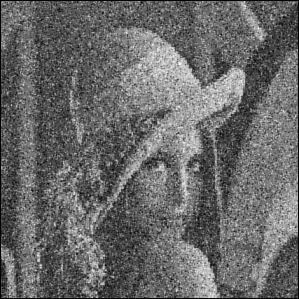

In [ ]:
def mascara4(imagem):
  imagem_array = np.array(imagem)

  #prioriza bordas na vertical
  mascara = np.array([[0, 1/8, 0],
                      [1/8, 4/8, 1/8],
                      [0, 1/8, 0]])

  altura, largura = imagem_array.shape

  #criando uma matriz para armazenar o resultado da convolução
  resultado = np.zeros((altura, largura))

  #aplicando a convolução pixel a pixel
  for i in range(1, altura-1):
      for j in range(1, largura-1):
          #vizinhança
          vizinhos = np.array([[imagem_array[i+1, j-1], imagem_array[i+1, j], imagem_array[i+1, j+1]],
                              [imagem_array[i, j-1], imagem_array[i, j], imagem_array[i, j+1]],
                              [imagem_array[i-1, j-1], imagem_array[i-1, j], imagem_array[i-1, j+1]]])

          #extrai uma matriz 3x3 da imagem em torno do pixel central (i, j)
          resultado[i, j] = np.sum(vizinhos * mascara)

  #normalizando os valores para o intervalo [0, 255]
  resultado = np.clip(resultado, 0, 255)

  #convertendo de volta para o tipo de dados uint8
  resultado = resultado.astype(np.uint8)

  return Image.fromarray(resultado)

resultado = mascara4(lena_ruido)

resultado

**OPERAÇÕES MORFOLÓGICAS - UNIÃO**

A U B = { máx (a, b) | a E A, b E B }

In [ ]:
import numpy as np
from PIL import Image

def uniao_morfologica(imagem1, imagem2):

    #converte as imagens para arrays NumPy
    array1 = np.array(imagem1)
    array2 = np.array(imagem2)

    #obtém as dimensões das imagens
    altura, largura = array1.shape

    #cria uma matriz para armazenar o resultado da operação morfológica
    resultado = np.zeros((altura, largura), dtype=np.uint8)

    #itera sobre cada pixel
    for i in range(altura):
        for j in range(largura):
            #define o valor do pixel resultante como o máximo entre os valores das duas imagens
            resultado[i, j] = max(array1[i, j], array2[i, j])

    #converte a matriz resultante de volta para uma imagem
    imagem_resultante = Image.fromarray(resultado)

    return imagem_resultante

**OPERAÇÕES MORFOLÓGICAS - INTERSEÇÃO**:

A interseção B = { mín (a, b) | a E A, b E B }


In [ ]:
import numpy as np
from PIL import Image

def interseção_morfologica(imagem1, imagem2):
    #converte as imagens para arrays NumPy
    array1 = np.array(imagem1)
    array2 = np.array(imagem2)

    #obtém as dimensões das imagens
    altura, largura = array1.shape

    #cria uma matriz para armazenar o resultado da operação morfológica
    resultado = np.zeros((altura, largura), dtype=np.uint8)

    #itera sobre cada pixel
    for i in range(altura):
        for j in range(largura):
            #define o valor do pixel resultante como o mínimo entre os valores das duas imagens
            resultado[i, j] = min(array1[i, j], array2[i, j])

    #converte a matriz resultante de volta para uma imagem
    imagem_resultante = Image.fromarray(resultado)

    return imagem_resultante

**OPERAÇÕES MORFOLÓGICAS - DIFERENÇA:**

A - B = { a - b | a E A, b E B }

In [ ]:
import numpy as np
from PIL import Image

def diferença_morfologica(imagem1, imagem2):
    #converte as imagens para arrays NumPy
    array1 = np.array(imagem1)
    array2 = np.array(imagem2)

    #obtém as dimensões das imagens
    altura, largura = array1.shape

    #cria uma matriz para armazenar o resultado da operação morfológica
    resultado = np.zeros((altura, largura), dtype=np.uint8)

    #itera sobre cada pixel
    for i in range(altura):
        for j in range(largura):
            #define o valor do pixel resultante como a diferença entre os valores das duas imagens
            resultado = max(array1[i, j] - array2[i, j], 0)

    #converte a matriz resultante de volta para uma imagem
    imagem_resultante = Image.fromarray(imagem_resultante)

    return imagem_resultante

**OPERAÇÕES MORFOLÓGICAS - DILATAÇÃO**

In [ ]:
import numpy as np

def dilatacao(imagem, elemento_estruturante, centro_elemento):
    imagem = np.array(imagem)
    elemento_estruturante = np.array(elemento_estruturante)

    altura_imagem, largura_imagem = imagem.shape
    altura_elemento, largura_elemento = elemento_estruturante.shape

    imagem_dilatada = np.zeros_like(imagem)

    for i in range(altura_imagem):
        for j in range(largura_imagem):
            if imagem[i, j] == 1:  #verifica se o pixel na imagem é 1
                for x in range(altura_elemento):
                    for y in range(largura_elemento):
                        #iterando sobre os vizinhos do centro do elemento estruturante
                        vizinho_x, vizinho_y = i + x - centro_elemento[0], j + y - centro_elemento[1]
                        #verifica se o vizinho está dentro dos limites da imagem e se ele tem o valor 1
                        if 0 <= vizinho_x < altura_imagem and 0 <= vizinho_y < largura_imagem and elemento_estruturante[x, y] == 1:
                            #se sim, o pixel correspondente na imagem dilatada também tem que receber valor 1
                            imagem_dilatada[vizinho_x, vizinho_y] = 1

    return imagem_dilatada

*Teste da dilatação:*

In [ ]:
#exemplo de uso:
imagem = np.array([
    [0, 0, 0, 0, 0],
    [0, 1, 0, 0, 0],
    [0, 1, 0, 0, 0],
    [0, 1, 0, 0, 0],
    [0, 0, 0, 0, 0]
])

elemento_estruturante = np.array([
    [1, 1, 1],
    [1, 1, 1],
    [1, 1, 1]
])

centro_elemento = (1, 1)

imagem_dilatada = dilatacao(imagem, elemento_estruturante, centro_elemento)

#exibindo a imagem original e a imagem dilatada
print("Imagem Original:")
print(imagem)

print("\nImagem Dilatada:")
print(imagem_dilatada)

Imagem Original:
[[0 0 0 0 0]
 [0 1 0 0 0]
 [0 1 0 0 0]
 [0 1 0 0 0]
 [0 0 0 0 0]]

Imagem Dilatada:
[[1 1 1 0 0]
 [1 1 1 0 0]
 [1 1 1 0 0]
 [1 1 1 0 0]
 [1 1 1 0 0]]


**OPERAÇÕES MORFOLÓGICAS - EROSÃO**

In [ ]:
import numpy as np

def erosao(imagem, elemento_estruturante, centro_elemento):
    imagem = np.array(imagem)
    elemento_estruturante = np.array(elemento_estruturante)

    altura_imagem, largura_imagem = imagem.shape[:2]
    altura_elemento, largura_elemento = elemento_estruturante.shape

    imagem_erodida = np.zeros_like(imagem)

    for i in range(altura_imagem):
        for j in range(largura_imagem):
            elemento_cabendo = True

            for x in range(altura_elemento):
                for y in range(largura_elemento):
                    #percorre os pixels ao redor do centro no elemento estruturante (com coordenadas da imagem, não do ES)
                    vizinho_x, vizinho_y = i + x - centro_elemento[0], j + y - centro_elemento[1]

                    """se o pixel do ES está fora dos intervalos da imagem ou se o seu valor não couber (1 sobre 1 ou 0 sobre 0)
                        no pixel da imagem, quer dizer que ele não cabe naquele ponto da imagem"""
                    if not (0 <= vizinho_x < altura_imagem and 0 <= vizinho_y < largura_imagem) or elemento_estruturante[x, y] != imagem[vizinho_x, vizinho_y]:
                        elemento_cabendo = False
                        break

                #se não cabe, ele para de percorrer o ES e aquele pixel fica com valor de 0
                if not elemento_cabendo:
                    break

            #se cabe, o valor do centro na imagem resultante é 1
            if elemento_cabendo:
                imagem_erodida[i, j] = 1

    return imagem_erodida

*Teste de erosão:*

In [ ]:
#exemplo de uso:
imagem = np.array([
    [1, 1, 1, 1, 1],
    [1, 1, 1, 1, 1],
    [1, 1, 1, 1, 1],
    [1, 1, 1, 0, 1],
    [1, 1, 1, 1, 1]
])

elemento_estruturante = np.array([
    [1, 1, 1],
    [1, 1, 1],
    [1, 1, 1]
])

centro_elemento = (1, 1)

imagem_erodida = erosao(imagem, elemento_estruturante, centro_elemento)

#exibindo a imagem original e a imagem erodida
print("Imagem Original:")
print(imagem)

print("\nImagem Erodida:")
print(imagem_erodida)

Imagem Original:
[[1 1 1 1 1]
 [1 1 1 1 1]
 [1 1 1 1 1]
 [1 1 1 0 1]
 [1 1 1 1 1]]

Imagem Erodida:
[[0 0 0 0 0]
 [0 1 1 1 0]
 [0 1 0 0 0]
 [0 1 0 0 0]
 [0 0 0 0 0]]


**OPERAÇÕES MORFOLÓGICAS - ABERTURA**

In [ ]:
def abertura(imagem, elemento_estruturante, centro_elemento):
    imagem = np.array(imagem)
    elemento_estruturante = np.array(elemento_estruturante)

    imagem_erodida = erosao(imagem, elemento_estruturante, centro_elemento)
    imagem_abertura = dilatacao(imagem_erodida, elemento_estruturante, centro_elemento)
    return imagem_abertura

*Teste da abertura:*

In [ ]:
#exemplo de uso:
imagem = np.array([
    [0, 0, 0, 1, 1],
    [0, 1, 1, 1, 1],
    [0, 1, 1, 1, 1],
    [0, 1, 1, 1, 0],
    [0, 0, 0, 0, 0]
])

elemento_estruturante = np.array([
    [1, 1, 1],
    [1, 1, 1],
    [1, 1, 1]
])

centro_elemento = (1, 1)

imagem_abertura = abertura(imagem, elemento_estruturante, centro_elemento)

#exibindo a imagem original e a imagem após abertura
print("Imagem Original:")
print(imagem)

print("\nImagem após Abertura:")
print(imagem_abertura)

Imagem Original:
[[0 0 0 1 1]
 [0 1 1 1 1]
 [0 1 1 1 1]
 [0 1 1 1 0]
 [0 0 0 0 0]]

Imagem após Abertura:
[[0 0 0 0 0]
 [0 1 1 1 0]
 [0 1 1 1 0]
 [0 1 1 1 0]
 [0 0 0 0 0]]


**OPERAÇÕES MORFOLÓGICAS - FECHAMENTO**

In [ ]:
def fechamento(imagem, elemento_estruturante, centro_elemento):
    imagem_dilatada = dilatacao(imagem, elemento_estruturante, centro_elemento)
    imagem_fechamento = erosao(imagem_dilatada, elemento_estruturante, centro_elemento)
    return imagem_fechamento

*Teste do fechamento:*

In [ ]:
#exemplo de uso:
imagem = np.array([
    [0, 0, 0, 0, 0],
    [0, 1, 1, 1, 1],
    [0, 0, 0, 1, 1],
    [0, 0, 1, 1, 0],
    [0, 0, 0, 0, 0]
])

elemento_estruturante = np.array([
    [1, 1, 1],
    [1, 1, 1],
    [1, 1, 1]
])

centro_elemento = (1, 1)

imagem_fechamento = fechamento(imagem, elemento_estruturante, centro_elemento)

#exibindo a imagem original e a imagem após fechamento
print("Imagem Original:")
print(imagem)

print("\nImagem após Fechamento:")
print(imagem_fechamento)

Imagem Original:
[[0 0 0 0 0]
 [0 1 1 1 1]
 [0 0 0 1 1]
 [0 0 1 1 0]
 [0 0 0 0 0]]

Imagem após Fechamento:
[[0 0 0 0 0]
 [0 1 1 1 0]
 [0 0 1 1 0]
 [0 0 1 1 0]
 [0 0 0 0 0]]


**ALGORITMOS - PREENCHIMENTO DE BURACOS DOS OBJETOS PRETOS**


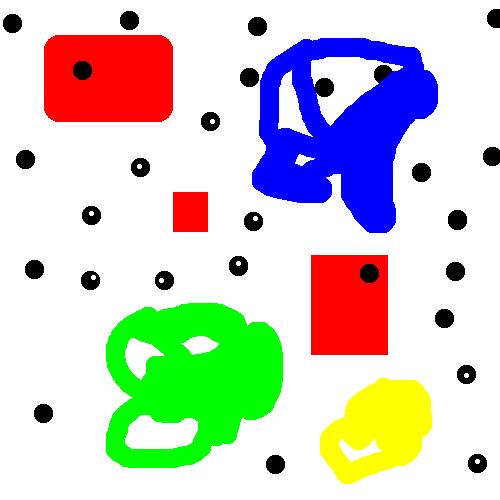

In [ ]:
quadro_original = Image.open('/content/quadro.png')
quadro_original

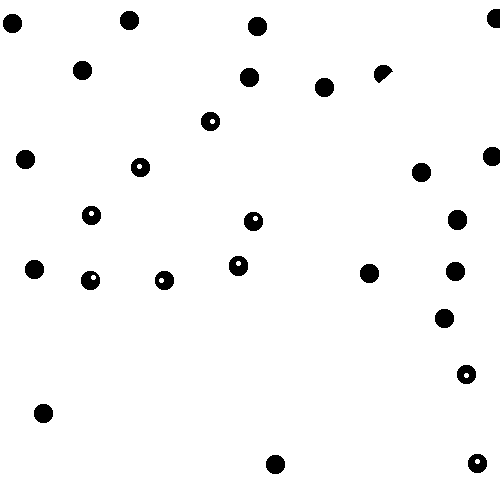

In [ ]:
def extrair_objetos_pretos(imagem):
    # Converter a imagem para um array numpy
    array_imagem = np.array(imagem)

    # Identificar os objetos pretos na imagem
    # Verifica se os 3 canais (RGB) dos pixels são 0 simultaneamente (pixel é preto)
    objetos_pretos = (array_imagem[:, :, 0] == 0) & (array_imagem[:, :, 1] == 0) & (array_imagem[:, :, 2] == 0)

    # Aplicar a máscara para obter apenas os objetos pretos
    resultado = array_imagem.copy()
    resultado[~objetos_pretos] = 255  # Negar a máscara para preservar os pixels pretos

    # Converter o resultado de volta para uma imagem PIL
    imagem_com_pretos = Image.fromarray(resultado.astype(np.uint8))

    return imagem_com_pretos

objetos_pretos = extrair_objetos_pretos(quadro_original)
objetos_pretos

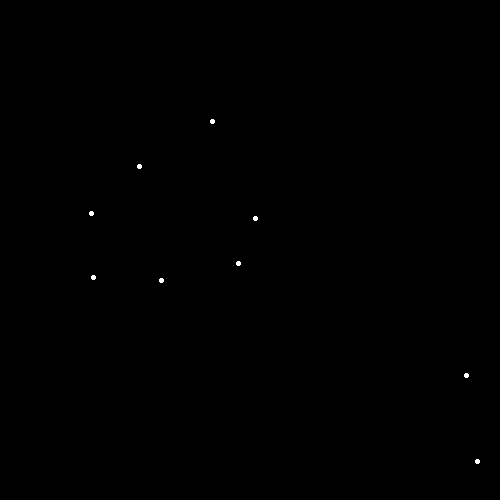

In [ ]:
def flood_fill(image, start_point, new_value):
    stack = [start_point]
    original_value = image.getpixel(start_point)

    while stack:
        x, y = stack.pop()

        if image.getpixel((x, y)) == original_value:
            image.putpixel((x, y), new_value)

            if x > 0:
                stack.append((x - 1, y))
            if x < image.width - 1:
                stack.append((x + 1, y))
            if y > 0:
                stack.append((x, y - 1))
            if y < image.height - 1:
                stack.append((x, y + 1))

def extrair_buracos(imagem):
    largura, altura = imagem.size

    imagem_processada = imagem.copy()

    flood_fill(imagem_processada, (0, 0), 100)
    flood_fill(imagem_processada, (0, 0), 0)

    return imagem_processada

def extrai_buracos_rgb(imagem, cor_objeto=None):
    largura, altura = imagem.size

    # Cria uma cópia da imagem
    imagem_processada = imagem.copy()

    # Pintando o fundo
    flood_fill(imagem_processada, (0, 0), (cor_objeto))
    flood_fill(imagem_processada, (0, 0), (0, 0, 0))

    return imagem_processada

buracos = extrair_buracos(objetos_pretos.convert('L'))
buracos

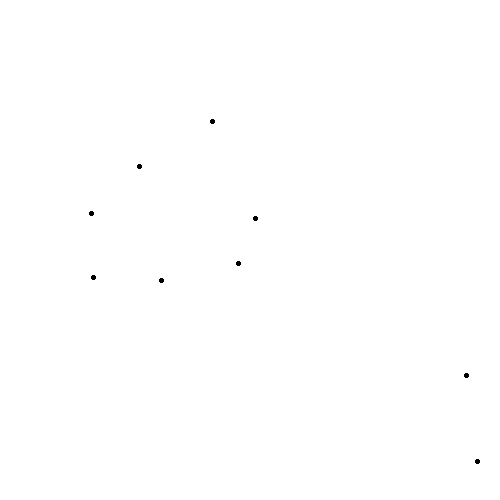

In [ ]:
def complemento_imagem(imagem):
    largura, altura = imagem.size

    # Cria uma cópia da imagem
    imagem_complemento = imagem.copy()

    # Itera pelos pixels e calcula o complemento
    for x in range(largura):
        for y in range(altura):
            pixel = imagem.getpixel((x, y))
            complemento_pixel = 255 - pixel
            imagem_complemento.putpixel((x, y), complemento_pixel)

    return imagem_complemento

buracos_complemento = complemento_imagem(buracos)
buracos_complemento

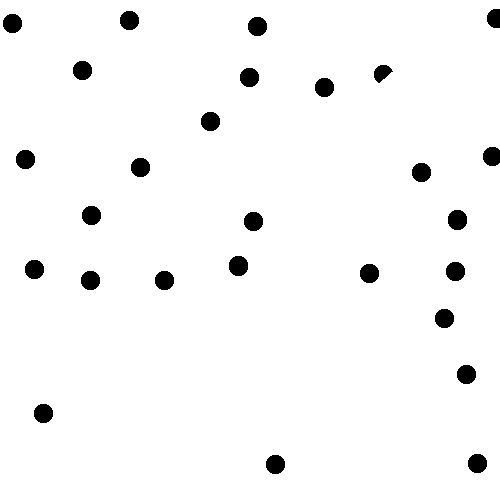

In [ ]:
resultado_preenchido = interseção_morfologica(objetos_pretos.convert('L'), buracos_complemento)
resultado_preenchido

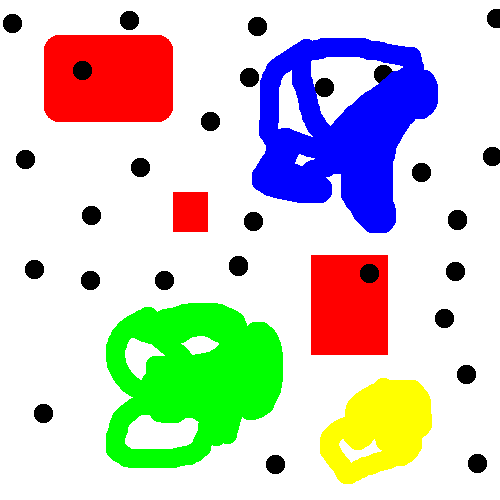

In [ ]:
def preenche_pretos(imagem1, imagem2):
    largura, altura = imagem1.size

    image = imagem1.copy()
    image = image.convert('RGB')
    imagem2 = imagem2.convert('L')

    for i in range(altura):
        for j in range(largura):
            if (imagem2.getpixel((j, i)) == 0):
                image.putpixel((j, i), (0, 0, 0))

    return image

def preenche_cor(imagem1, imagem2, cor_alvo):
    largura, altura = imagem1.size

    image = imagem1.copy()
    image = image.convert('RGB')
    imagem2 = imagem2.convert('RGB')  # Certifique-se de que a imagem2 está em modo RGB

    for i in range(altura):
        for j in range(largura):
            # Verifique se o pixel na imagem2 é branco (buraco)
            if imagem2.getpixel((j, i)) == (255, 255, 255):
                image.putpixel((j, i), cor_alvo)

    return image

quadro_pretos_preenc = preenche_pretos(quadro_original, resultado_preenchido)
quadro_pretos_preenc

**IMAGEM SEM OBJETOS PRETOS**

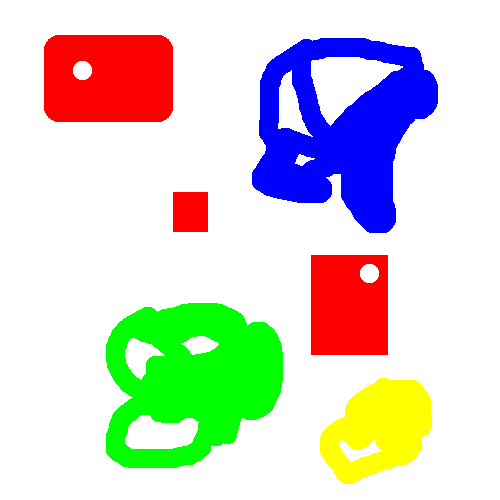

In [ ]:
def eliminar_objetos_pretos(imagem):
    # Converter a imagem para um array numpy
    array_imagem = np.array(imagem)

    # Identificar os objetos pretos na imagem
    # verifica se os 3 canais (RGB) dos pixels são 0 simultaneamente (pixel é preto)
    objetos_pretos = (array_imagem[:, :, 0] == 0) & (array_imagem[:, :, 1] == 0) & (array_imagem[:, :, 2] == 0)

    # Criar uma máscara para os objetos pretos
    # pixels correspondentes aos objetos pretos são definidos como 0 e o restante como 1
    mascara = np.ones_like(array_imagem) * 255
    mascara[objetos_pretos] = 0

    # Aplicar a máscara para eliminar os objetos pretos
    resultado = np.bitwise_and(array_imagem, mascara)

    # Converter o resultado de volta para uma imagem PIL
    imagem_sem_pretos = Image.fromarray(resultado.astype(np.uint8))

    return imagem_sem_pretos

# Exemplo de uso
imagem_original = Image.open('/content/quadro.png')

# Eliminar objetos pretos na imagem
imagem_sem_pretos = eliminar_objetos_pretos(imagem_original)

# Exibir imagem original e processada
imagem_original
imagem_sem_pretos

**ALGORITMOS - PREENCHIMENTO DE BURACOS DOS OBJETOS VERDES**

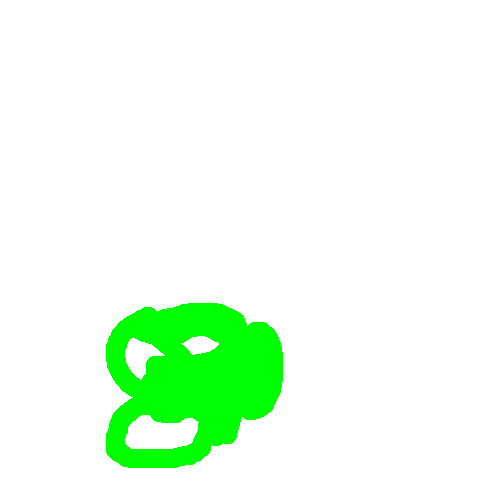

In [ ]:
def extrair_objetos_verdes(imagem):
    # Converter a imagem para um array numpy
    array_imagem = np.array(imagem)

    # Identificar os objetos verdes na imagem
    # Verifica se o canal G (RGB) dos pixels é 255
    objetos_verdes = (array_imagem[:, :, 0] == 0) & (array_imagem[:, :, 1] == 255) & (array_imagem[:, :, 2] == 0)

    # Aplicar a máscara para obter apenas os objetos verdes
    resultado = array_imagem.copy()
    resultado[~objetos_verdes] = 255  # Negar a máscara para preservar os pixels verdes

    # Converter o resultado de volta para uma imagem PIL
    imagem_com_verdes = Image.fromarray(resultado.astype(np.uint8))

    return imagem_com_verdes

objetos_verdes = extrair_objetos_verdes(quadro_original)
objetos_verdes

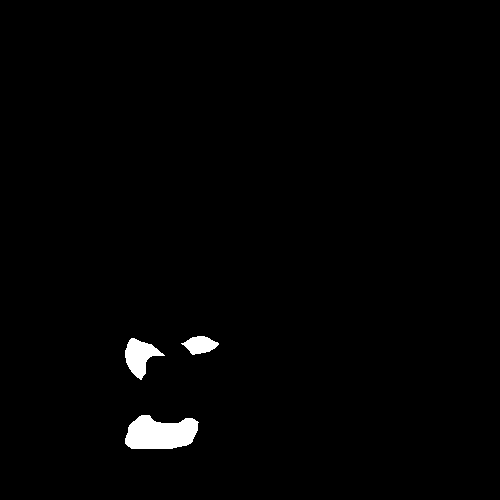

In [ ]:
buracos_verdes = extrai_buracos_rgb(objetos_verdes, (0, 255, 0))
buracos_verdes

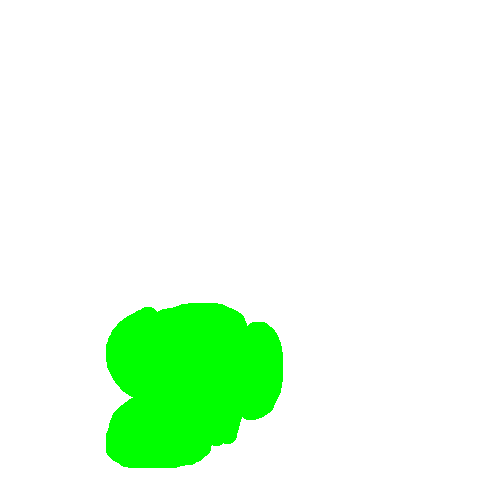

In [ ]:
apenas_verde =  preenche_cor(objetos_verdes, buracos_verdes, (0, 255, 0))
apenas_verde

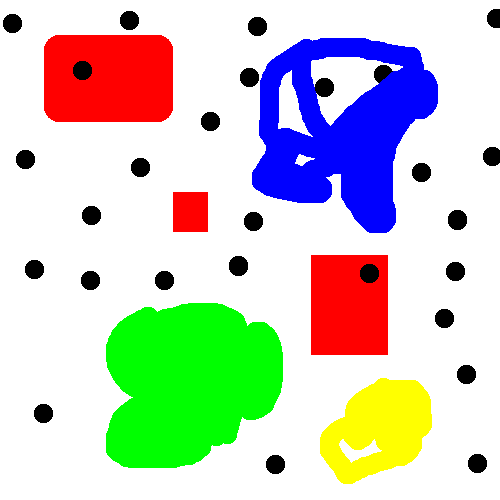

In [ ]:
quadro_verdes_preenc = preenche_cor(quadro_pretos_preenc, buracos_verdes, (0, 255, 0))
quadro_verdes_preenc

**ALGORITMOS - PREENCHIMENTO DE BURACOS DOS OBJETOS AZUIS**

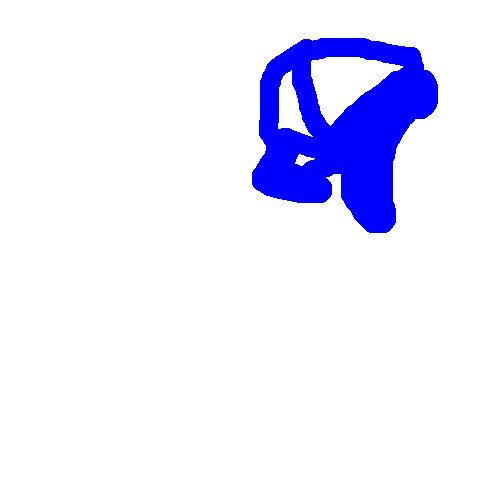

In [ ]:
def extrair_objetos_azuis(imagem):
    # Converter a imagem para um array numpy
    array_imagem = np.array(imagem)

    # Identificar os objetos azuis na imagem
    # Verifica se o canal B (RGB) dos pixels é 255
    objetos_azuis = (array_imagem[:, :, 0] == 0) & (array_imagem[:, :, 1] == 0) & (array_imagem[:, :, 2] == 255)

    # Aplicar a máscara para obter apenas os objetos azuis
    resultado = array_imagem.copy()
    resultado[~objetos_azuis] = 255  # Negar a máscara para preservar os pixels azuis

    # Converter o resultado de volta para uma imagem PIL
    imagem_com_azuis = Image.fromarray(resultado.astype(np.uint8))

    return imagem_com_azuis

objetos_azuis = extrair_objetos_azuis(quadro_original)
objetos_azuis

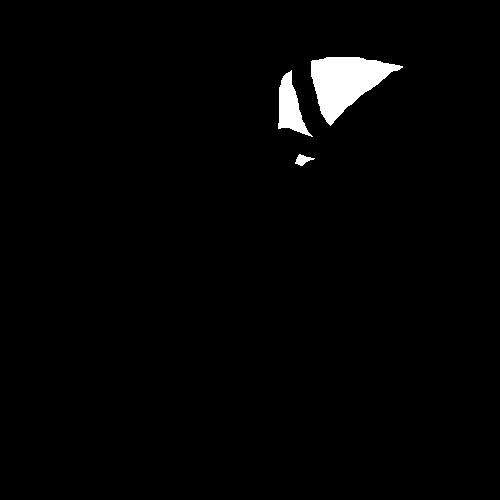

In [ ]:
buracos_azuis = extrai_buracos_rgb(objetos_azuis, (0, 0, 255))
buracos_azuis

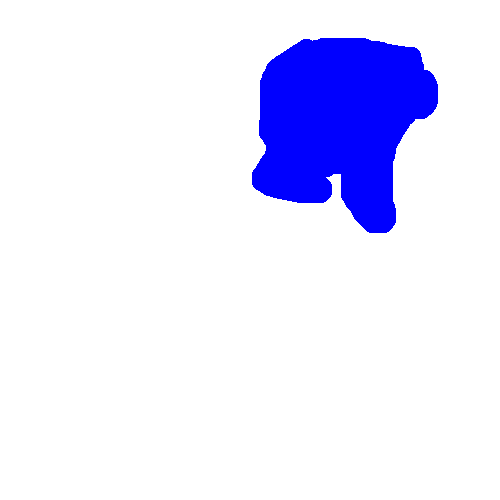

In [ ]:
apenas_azul =  preenche_cor(objetos_azuis, buracos_azuis, (0, 0, 255))
apenas_azul

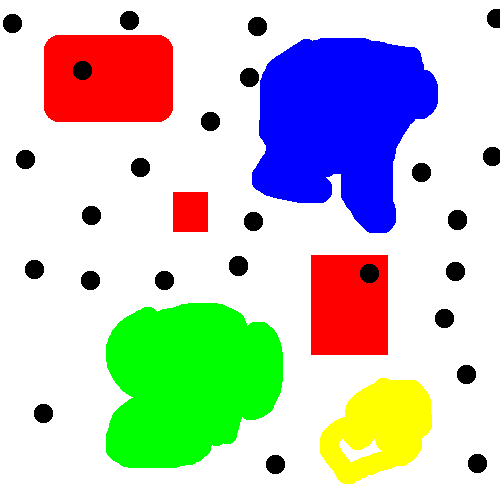

In [ ]:
quadro_azuis_preenc = preenche_cor(quadro_verdes_preenc, buracos_azuis, (0, 0, 255))
quadro_azuis_preenc

**ALGORITMOS - PREENCHIMENTO DE BURACOS DOS OBJETOS AMARELOS**

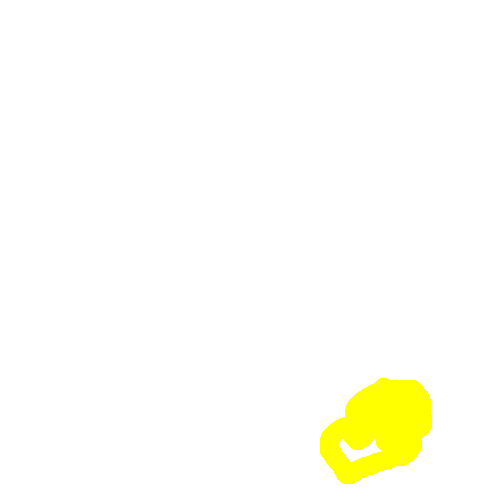

In [ ]:
def extrair_objetos_amarelos(imagem):
    # Converter a imagem para um array numpy
    array_imagem = np.array(imagem)

    # Identificar os objetos amarelos na imagem
    # Verifica se os canais R e G (RGB) dos pixels é 255
    objetos_amarelos = (array_imagem[:, :, 0] == 255) & (array_imagem[:, :, 1] == 255) & (array_imagem[:, :, 2] == 0)

    # Aplicar a máscara para obter apenas os objetos azuis
    resultado = array_imagem.copy()
    resultado[~objetos_amarelos] = 255  # Negar a máscara para preservar os pixels azuis

    # Converter o resultado de volta para uma imagem PIL
    imagem_com_amarelos = Image.fromarray(resultado.astype(np.uint8))

    return imagem_com_amarelos

objetos_amarelos = extrair_objetos_amarelos(quadro_original)
objetos_amarelos

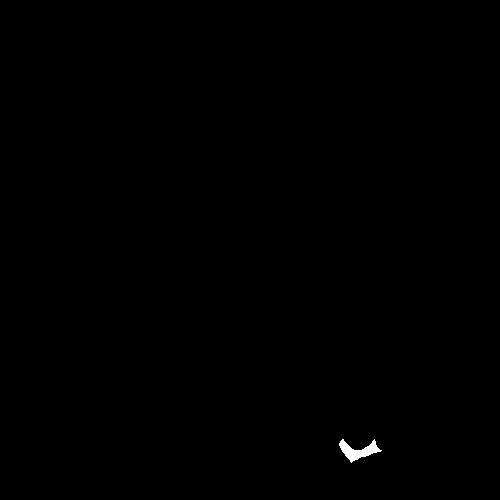

In [ ]:
buracos_amarelos = extrai_buracos_rgb(objetos_amarelos, (255, 255, 0))
buracos_amarelos

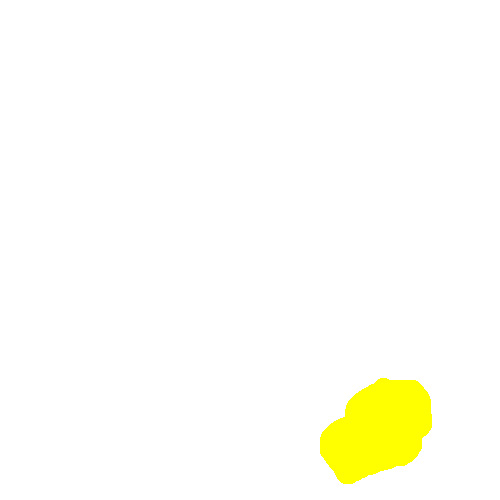

In [ ]:
apenas_amarelo =  preenche_cor(objetos_amarelos, buracos_amarelos, (255, 255, 0))
apenas_amarelo

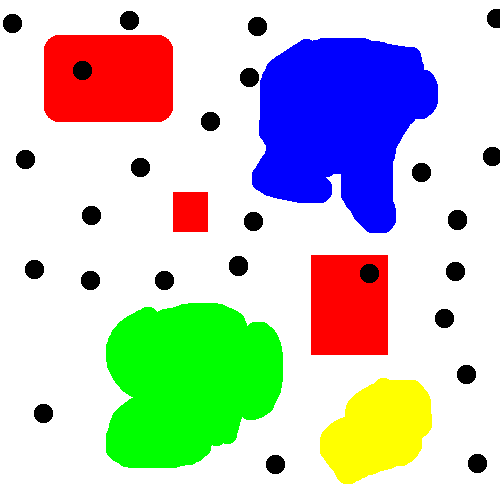

In [ ]:
quadro_amarelos_preenc = preenche_cor(quadro_azuis_preenc, buracos_amarelos, (255, 255, 0))
quadro_amarelos_preenc

**ALGORITMOS - HIT-OR-MISS**

In [ ]:
!pip install opencv-python

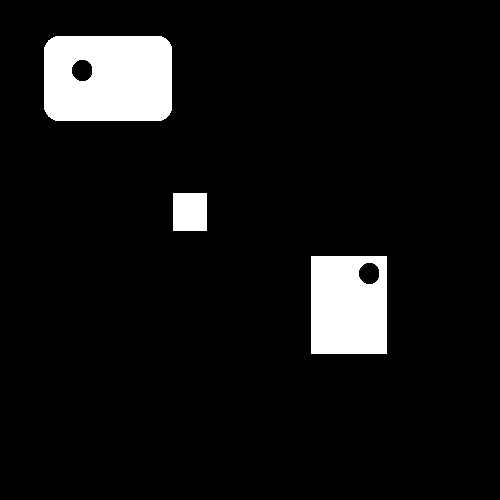

In [ ]:
import cv2
import numpy as np

# Carregue a imagem
imagem = cv2.imread('/content/quadro.png')

# Converta a imagem para o espaço de cores HSV
imagem_hsv = cv2.cvtColor(imagem, cv2.COLOR_BGR2HSV)

# Defina os intervalos de cor para objetos vermelhos
lower_red = np.array([0, 100, 100])
upper_red = np.array([10, 255, 255])

# Crie máscaras para as regiões de interesse
mascara1 = cv2.inRange(imagem_hsv, lower_red, upper_red)

# Agora, invertemos os intervalos para pegar os vermelhos mais claros
lower_red = np.array([160, 100, 100])
upper_red = np.array([180, 255, 255])

# Crie outra máscara
mascara2 = cv2.inRange(imagem_hsv, lower_red, upper_red)

# Combine as máscaras
mascara_final = cv2.bitwise_or(mascara1, mascara2)

# Aplique a Transformada Hit-or-Miss
kernel_hit = np.array([[0, 1, 0],
                       [0, 1, 1],
                       [0, 1, 0]], dtype=np.uint8)

kernel_miss = np.array([[1, 0, 1],
                        [1, 0, 0],
                        [1, 0, 1]], dtype=np.uint8)

resultado = cv2.morphologyEx(mascara_final, cv2.MORPH_HITMISS, kernel_hit - kernel_miss)

# Exiba a imagem original e o resultado
resultado = Image.fromarray(resultado)
resultado

**ALGORITMOS - ESQUELETIZAÇÃO**

In [ ]:
from PIL import Image, ImageChops
import numpy as np
from scipy.ndimage import binary_erosion, binary_dilation

def erosao(imagem_bin, elemento_B, centro):
    return binary_erosion(imagem_bin, structure=elemento_B, origin=centro).astype(int)

def abertura(imagem_bin, elemento_B, centro):
    return binary_dilation(erosao(imagem_bin, elemento_B, centro), structure=elemento_B, origin=centro).astype(int)

def diferenca_morfologica(imagem1, imagem2):
    return np.logical_and(imagem1, np.logical_not(imagem2)).astype(int)

def uniao_morfologica(imagem1, imagem2):
    return np.logical_or(imagem1, imagem2).astype(int)

def esqueleto(imagem):
    imagem_cinza = imagem.convert('L')
    imagem_binarizada = np.array(imagem_cinza.point(lambda pixel: 0 if pixel > 250 else 1, '1'))

    imagens = []

    k = 1
    referencia = np.zeros_like(imagem_binarizada)
    prox_erosao = erosao(imagem_binarizada, elemento_B, centro)

    erosoes = [imagem_binarizada, prox_erosao]

    # Descobrir o valor de k
    while np.sum(np.abs(referencia - prox_erosao)) > 0:
        referencia = prox_erosao
        prox_erosao = erosao(prox_erosao, elemento_B, centro)
        erosoes.append(prox_erosao)
        k += 1

    del(erosoes[-1])

    for i in range(k):
        Sa = erosoes[i]
        Sb = abertura(Sa, elemento_B, centro)
        Sc = diferenca_morfologica(Sa, Sb)
        imagens.append(Sc)

    imagem_final = imagens[0]
    for i in range(1, len(imagens)):
        imagem_final = uniao_morfologica(imagem_final, imagens[i])

    # Convertemos para o formato uint8 antes de criar a imagem final
    imagem_final = Image.fromarray((imagem_final * 255).astype(np.uint8), 'L')

    return imagem_final

# Substitua 'apenas_verde' pela sua imagem
elemento_B = np.array([[1, 1, 1],
                       [1, 1, 1],
                       [1, 1, 1]])
centro = (1, 1)

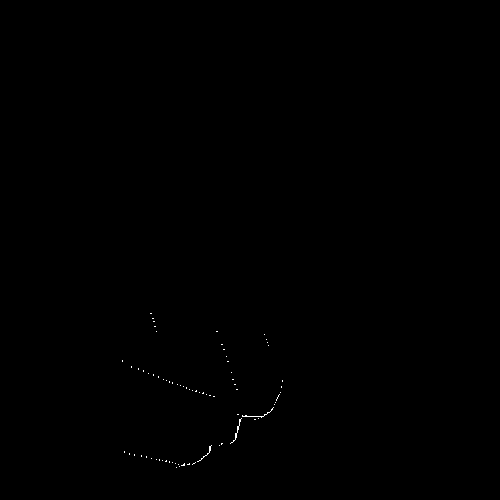

In [ ]:
# Exemplo de uso
esqueleto_verde = esqueleto(apenas_verde)
esqueleto_verde

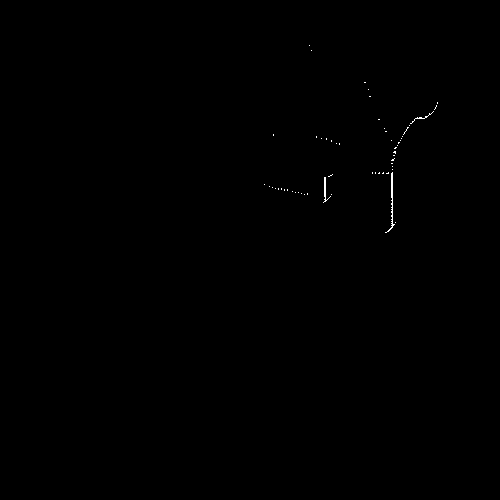

In [ ]:
# Exemplo de uso
esqueleto_azul = esqueleto(apenas_azul)
esqueleto_azul

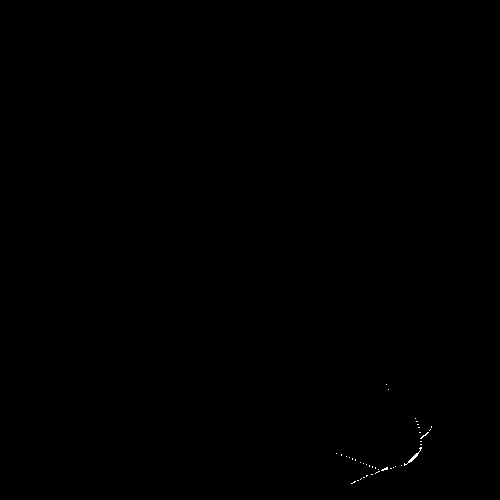

In [ ]:
# Exemplo de uso
esqueleto_amarelo = esqueleto(apenas_amarelo)
esqueleto_amarelo